In [69]:
import pandas as pd
from apyori import apriori
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df_retail = pd.read_csv('online retail.csv',header=0,encoding = 'unicode_escape')

In [3]:
df_retail.info()
print(df_retail.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532619 entries, 0 to 532618
Data columns (total 8 columns):
InvoiceNo      532619 non-null object
StockCode      532619 non-null object
Description    531165 non-null object
Quantity       532619 non-null int64
InvoiceDate    532619 non-null object
UnitPrice      532619 non-null float64
CustomerID     397924 non-null float64
Country        532619 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 32.5+ MB
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21

In [4]:
def describeDataset(doc):
    """
    Print Details for each column
    """
    for cols in doc:
        print(df_retail[cols].unique())
        print(df_retail[cols].value_counts())
        print("-"*20)
        
describeDataset(df_retail)

[536365 536366 536367 ... 581585 581586 581587]
573585    1114
581219     749
581492     731
580729     721
558475     705
579777     687
581217     676
537434     675
580730     662
538071     652
580367     650
580115     645
581439     635
580983     629
578344     622
538349     620
578347     606
537638     601
537237     597
536876     593
576617     593
536592     592
537823     591
576837     585
579508     578
577078     572
537240     568
577358     561
576618     552
576840     544
          ... 
541903       1
560037       1
560032       1
541882       1
549103       1
559946       1
574516       1
574518       1
549106       1
549107       1
574520       1
559945       1
559943       1
559936       1
561565       1
574546       1
574549       1
565192       1
574576       1
574577       1
564196       1
574579       1
574580       1
574581       1
574582       1
574583       1
574585       1
549132       1
541840       1
556311       1
Name: InvoiceNo, Length: 22064, dtype

## 1. Can you identify data quality issues in this dataset for performing association analysis?

In [5]:
#remove negative values in quantiy column as it is not necessaory values in terms of analysis of association.
df_retail.drop(df_retail[df_retail.Quantity < 0].index, inplace=True)

In [15]:
# remove inappropriate values in StockCode
df_retail['StockCode'].replace(['85123A','85099B'],['85123','85099'],inplace = True)
df_retail.drop(df_retail[df_retail.StockCode == 'DCGS0073'].index, inplace=True)
df_retail.drop(df_retail[df_retail.StockCode == 'DCGS0069'].index, inplace=True) 
df_retail.drop(df_retail[df_retail.StockCode == 'DCGS0068'].index, inplace=True) 
df_retail.drop(df_retail[df_retail.StockCode == 'DCGS0067'].index, inplace=True) 
df_retail.drop(df_retail[df_retail.StockCode == 'DCGS0003'].index, inplace=True) 
df_retail.drop(df_retail[df_retail.StockCode == 'm'].index, inplace=True)
df_retail.drop(df_retail[df_retail.StockCode == 'POST'].index, inplace=True)
df_retail.drop(df_retail[df_retail.StockCode == 'S'].index, inplace=True)

In [16]:
df_retail['StockCode'].unique()
df_retail['StockCode'].value_counts()

85123     2270
85099     2115
22423     2019
47566     1707
20725     1595
84879     1489
22197     1426
22720     1401
21212     1370
20727     1328
22383     1327
22457     1263
23203     1250
22386     1238
22469     1227
22086     1200
21931     1197
22411     1190
22382     1179
20728     1174
22961     1169
23298     1167
22960     1142
22666     1133
23209     1124
22384     1117
82482     1111
22993     1102
22699     1084
22727     1074
          ... 
84031a       1
16169N       1
85160a       1
17001        1
84971L       1
46776f       1
85224        1
72803B       1
90048        1
79323P       1
46776a       1
22146        1
90021        1
20703        1
85049c       1
90069        1
85036b       1
84550        1
23652        1
23609        1
23843        1
85034b       1
35592T       1
85044        1
84510e       1
90135A       1
90026A       1
47591b       1
85031B       1
84613C       1
Name: StockCode, Length: 3930, dtype: int64

## 2. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.

In [31]:
df_retail = df_retail.dropna(subset = ['Description'])

In [41]:
transactions = df_retail.groupby(['InvoiceNo'])['Description'].apply(list)
print(transactions.head(5))

InvoiceNo
536365    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
536366    [HAND WARMER UNION JACK, HAND WARMER RED POLKA...
536367    [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
536368    [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
536369                           [BATH BUILDING BLOCK WORD]
Name: Description, dtype: object


InvoiveNo and Description were variables are included in the analysis.

## 3. Conduct association mining and answer the following: a. What is the highest lift value for the resulting rules? Which rule has this value? 

In [61]:
def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 


In [62]:
# type cast the transactions from pandas into normal list format and run apriori
transaction_list = list(transactions)
results = list(apriori(transaction_list, min_support=0.005, min_confidence = 0.2, min_lift = 3, min_length = 2, max_length = 2))

# print first 5 rules
print(results[:5])


[RelationRecord(items=frozenset({'SPACEBOY BEAKER', ' DOLLY GIRL BEAKER'}), support=0.00601649684619117, ordered_statistics=[OrderedStatistic(items_base=frozenset({' DOLLY GIRL BEAKER'}), items_add=frozenset({'SPACEBOY BEAKER'}), confidence=0.7126436781609196, lift=79.82383808095952), OrderedStatistic(items_base=frozenset({'SPACEBOY BEAKER'}), items_add=frozenset({' DOLLY GIRL BEAKER'}), confidence=0.6739130434782609, lift=79.82383808095952)]), RelationRecord(items=frozenset({'12 PENCIL SMALL TUBE WOODLAND', '12 PENCILS SMALL TUBE RED RETROSPOT'}), support=0.006453178068898593, ordered_statistics=[OrderedStatistic(items_base=frozenset({'12 PENCIL SMALL TUBE WOODLAND'}), items_add=frozenset({'12 PENCILS SMALL TUBE RED RETROSPOT'}), confidence=0.37464788732394366, lift=21.33009104349856), OrderedStatistic(items_base=frozenset({'12 PENCILS SMALL TUBE RED RETROSPOT'}), items_add=frozenset({'12 PENCIL SMALL TUBE WOODLAND'}), confidence=0.367403314917127, lift=21.330091043498555)]), Relation

In [63]:
result_df = convert_apriori_results_to_pandas_df(results)
print(result_df.head(20))

                              Left_side                           Right_side  \
0                     DOLLY GIRL BEAKER                      SPACEBOY BEAKER   
1                       SPACEBOY BEAKER                    DOLLY GIRL BEAKER   
2         12 PENCIL SMALL TUBE WOODLAND  12 PENCILS SMALL TUBE RED RETROSPOT   
3   12 PENCILS SMALL TUBE RED RETROSPOT        12 PENCIL SMALL TUBE WOODLAND   
4         12 PENCIL SMALL TUBE WOODLAND          12 PENCILS SMALL TUBE SKULL   
5           12 PENCILS SMALL TUBE SKULL        12 PENCIL SMALL TUBE WOODLAND   
6         12 PENCIL SMALL TUBE WOODLAND      PACK OF 72 RETROSPOT CAKE CASES   
7         12 PENCIL SMALL TUBE WOODLAND      PAPER CHAIN KIT 50'S CHRISTMAS    
8         12 PENCIL SMALL TUBE WOODLAND      SET 12 COLOUR PENCILS SPACEBOY    
9       SET 12 COLOUR PENCILS SPACEBOY         12 PENCIL SMALL TUBE WOODLAND   
10  12 PENCILS SMALL TUBE RED RETROSPOT          12 PENCILS SMALL TUBE SKULL   
11          12 PENCILS SMALL TUBE SKULL 

In [65]:
# sort all acquired rules descending by lift
result_df = result_df.sort_values(by='Lift', ascending=False)
print(result_df.head(15))

                                Left_side  \
1370  CHRISTMAS TREE DECORATION WITH BELL   
1371      CHRISTMAS TREE HEART DECORATION   
1372  CHRISTMAS TREE DECORATION WITH BELL   
1373       CHRISTMAS TREE STAR DECORATION   
5291           SET/6 COLLAGE PAPER PLATES   
5290             SET/6 COLLAGE PAPER CUPS   
4167           PACK OF 6 SKULL PAPER CUPS   
4168         PACK OF 6 SKULL PAPER PLATES   
1468            DOLLY GIRL CHILDRENS BOWL   
1469             DOLLY GIRL CHILDRENS CUP   
1375       CHRISTMAS TREE STAR DECORATION   
1374      CHRISTMAS TREE HEART DECORATION   
2400                    HERB MARKER THYME   
2399                 HERB MARKER ROSEMARY   
2384                  HERB MARKER PARSLEY   

                               Right_side   Support  Confidence        Lift  
1370      CHRISTMAS TREE HEART DECORATION  0.005337    0.880000  100.760000  
1371  CHRISTMAS TREE DECORATION WITH BELL  0.005337    0.611111  100.760000  
1372       CHRISTMAS TREE STAR DECORATION  0.

From the result above, the highest lift value is 100.76. There re two rules having this value: 
CHRISTMAS TREE DECORATION WITH BELL -> CHRISTMAS TREE HEART DECORATION and CHRISTMAS TREE HEART DECORATION -> CHRISTMAS TREE DECORATION WITH BELL.  

## b. What is the highest confidence value for the resulting rules? Which rule has this value? 

In [66]:
result_df = result_df.sort_values(by='Confidence', ascending=False)
print(result_df.head(15))

                                Left_side                          Right_side  \
477   BEADED CRYSTAL HEART GREEN ON STICK                      DOTCOM POSTAGE   
492    BEADED CRYSTAL HEART PINK ON STICK                      DOTCOM POSTAGE   
779              CANDY SPOT CUSHION COVER                      DOTCOM POSTAGE   
2400                    HERB MARKER THYME                HERB MARKER ROSEMARY   
2383                  HERB MARKER CHIVES                  HERB MARKER PARSLEY   
2399                 HERB MARKER ROSEMARY                   HERB MARKER THYME   
1780                SOFT PINK ROSE TOWEL                       DOTCOM POSTAGE   
4946               REGENCY TEA PLATE PINK            REGENCY TEA PLATE GREEN    
2381                  HERB MARKER CHIVES                     HERB MARKER MINT   
2385                  HERB MARKER CHIVES                 HERB MARKER ROSEMARY   
2387                  HERB MARKER CHIVES                    HERB MARKER THYME   
2395                  HERB M

From the result above, the highest confidence value is 98.83%. The rule has this value is BEADED CRYSTAL HEART GREEN ON STICK -> DOTCOM POSTAGE. 

## c. Discuss and explain the results. Interpret them to discuss the rule-set obtained.

In [71]:
support = result_df['Support'].as_matrix()
confidence = result_df['Confidence'].as_matrix()
lift = result_df['Lift'].as_matrix()
lift

C:\Users\n10074520\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\n10074520\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\n10074520\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([28.77167915, 28.40361198, 27.48      , ...,  3.74727273,
        4.85512367,  4.6894198 ])

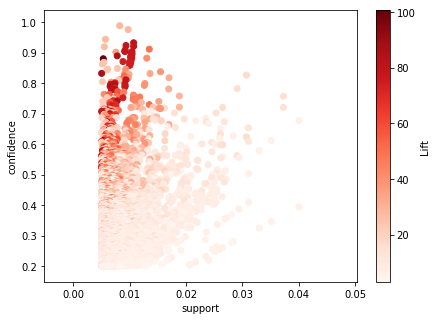

In [72]:
plt.figure(3, figsize=(7,5))
plt.scatter(support, confidence, c=lift, cmap='Reds')
plt.xlabel('support')
plt.ylabel('confidence') 

plt.colorbar().set_label('Lift')

## 4. The store is particularly interested in products that individuals purchase when they buy “HERB MARKER CHIVES”. 

### a. How many rules are in the subset?

There are 5 rules are in the subset.

In [74]:
search = result_df[result_df['Left_side'] == 'HERB MARKER CHIVES ']
print(search)

                Left_side            Right_side   Support  Confidence  \
2383  HERB MARKER CHIVES    HERB MARKER PARSLEY  0.009364    0.923445   
2381  HERB MARKER CHIVES       HERB MARKER MINT  0.009219    0.909091   
2385  HERB MARKER CHIVES   HERB MARKER ROSEMARY  0.009170    0.904306   
2387  HERB MARKER CHIVES      HERB MARKER THYME  0.009170    0.904306   
2372  HERB MARKER CHIVES      HERB MARKER BASIL  0.008831    0.870813   

           Lift  
2383  79.967231  
2381  78.068182  
2385  77.657297  
2387  78.640300  
2372  74.163075  


### b. Based on the rules, what are the other products these individuals are most likely to purchase? 

From the result above, the most common bought items with 'HERB MARKER CHIVES' are 'HERB MARKER PARSLEY', 'HERB MARKER MINT', 'HERB MARKER ROSEMARY'.

## 5. Can you perform sequence analysis on this dataset? If yes, present your results. If not, rationalise why?


## 6. How the outcome of this study can be used by decision makers?

The company can use the rules to obtain the understanding oc consumers' needs and behaviours. Decision makers will understand that there are several items that are often bought together. If they can put these items together, revenue can get increased. 